<a href="https://colab.research.google.com/github/SuperMusey/FoundationOfPrivacy/blob/main/MIA_phase2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIA FOR Finetuned LLM

In [1]:
# Save to cloud
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# update the downloading command as my LFS runs out so cannot directly clone model.safetensors
%cd /content

!git clone https://github.com/2020pyfcrawl/18734-17731_Project_Phase2_3.git

%cd /content/18734-17731_Project_Phase2_3


/content
Cloning into '18734-17731_Project_Phase2_3'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 58 (delta 10), reused 16 (delta 5), pack-reused 36 (from 1)
Receiving objects: 100% (58/58), 55.70 MiB | 38.93 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/18734-17731_Project_Phase2_3


### Variables and libraries

In [ ]:
# install the required libraries if you have not done so (on you local machine or GPU server)
# you may not need to run this if you use colab as they are pre-installed, but you can always do it.
%pip install -r requirements.txt

In [3]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [4]:
# global variable, check the current position to adjust the path
phase = "train" # or train / val / final
target_model_dir = f"./models/{phase}/gpt2_3_lora32_adamw_b8_lr2"
data_dir = f"./data/{phase}/"
batch_size = 50

# you may change block size if you like (max length for the tokenizer below)
block_size = 512

### Data pre-processing

In [5]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [6]:
# for tests, you may only load a part of the data to save time while implementing,
# as running all 2000 samples on CPU may be slow, but not a problem here for GPU

# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you may load the model using the code:

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### MIA

Implement your attack here! \
Hint: use shadow models.

In [ ]:
@torch.no_grad()
def your_attack():
  pass
scores_test = your_attack()

SUPERVISED CANARY-BASED MIA (Memory Efficient)
Target test samples: 2000

Processing shadow model 0...
  Processing samples 0/2000
  Processing samples 100/2000
  Processing samples 200/2000
  Processing samples 300/2000
  Processing samples 400/2000
  Processing samples 500/2000
  Processing samples 600/2000
  Processing samples 700/2000
  Processing samples 800/2000
  Processing samples 900/2000
  Processing samples 1000/2000
  Processing samples 1100/2000
  Processing samples 1200/2000
  Processing samples 1300/2000
  Processing samples 1400/2000
  Processing samples 1500/2000
  Processing samples 1600/2000
  Processing samples 1700/2000
  Processing samples 1800/2000
  Processing samples 1900/2000
  Added 2000 samples (400 members)

Processing shadow model 1...
  Processing samples 0/2000
  Processing samples 100/2000
  Processing samples 200/2000
  Processing samples 300/2000
  Processing samples 400/2000
  Processing samples 500/2000
  Processing samples 600/2000
  Processing sam

### Result

In [ ]:
# load the label here to compute the performance, you will only have full access to the label in train set to test your method
if phase == "train":
    label_path = data_dir / "test_label.json"
    label_items = _read_json(label_path)

    y_true = np.array(label_items)
    scores = np.array(scores_test)
    fpr, tpr, thr = roc_curve(y_true, scores)
    auc_val = roc_auc_score(y_true, scores)
    print(auc_val)

    print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
    # WE ONLY CARE TPR @ 0.01FPR!!! SO INCREASE THIS AS MUCH AS POSSIBLE!!!
elif phase == "val" or phase == "final":
    pred_path = data_dir / "prediction.csv"
    with open(pred_path, "w", encoding="utf-8") as f:
        for s in scores_test:
            f.write(json.dumps(float(s), ensure_ascii=False) + "\n")
else:
    print("Wrong phase.")

0.5857104999999999
0.0


### Packaging the submission

zip the prediction file and upload to the leaderboard.

In [ ]:
import os
from pathlib import Path
import zipfile

with zipfile.ZipFile(f"project_submission.zip", 'w') as zipf:
    for phase in ["val", "final"]:
        data_dir = f"./data/{phase}/"
        data_dir = Path(data_dir)

        file = data_dir / "prediction.csv"
        if file.exists():
            arcname = os.path.join(phase, file.name)
            zipf.write(file, arcname=arcname)
        else:
            raise FileNotFoundError(f"`prediction.csv` not found in {data_dir}.")

FileNotFoundError: `prediction.csv` not found in data/val.

### Visualization

A few visualizations that may help you develop your method and write reports.

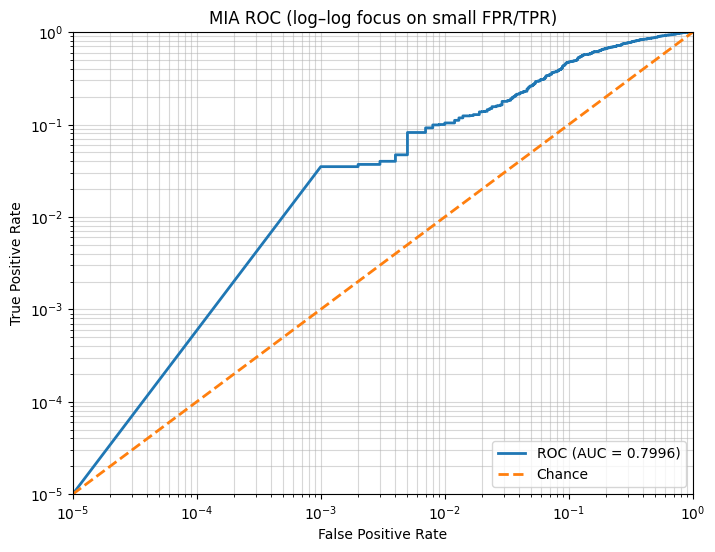

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-12
fpr_ = np.clip(fpr, 1e-5, 1)
tpr_ = np.clip(tpr, 1e-5, 1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_, tpr_, lw=2, label=f'ROC (AUC = {auc_val:.4f})')
ax.plot([1e-5, 1], [1e-5, 1], lw=2, ls='--', label='Chance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5, 1.0)
ax.set_ylim(1e-5, 1.0)

ticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.get_xaxis().set_minor_formatter(plt.NullFormatter())
ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('MIA ROC (log–log focus on small FPR/TPR)')
ax.legend(loc='lower right')
ax.grid(True, which='both', alpha=0.5)

plt.show()

In [ ]:
# Add this right before your visualization code
print("=== DEBUGGING SCORES_TEST ===")
print(f"scores_test type: {type(scores_test)}")
print(f"scores_test shape: {scores_test.shape}")
print(f"scores_test min: {scores_test.min():.4f}")
print(f"scores_test max: {scores_test.max():.4f}")
print(f"scores_test mean: {scores_test.mean():.4f}")

# Check for extreme values
extreme_high = np.sum(scores_test > 0.9)
extreme_low = np.sum(scores_test < 0.1)
print(f"Values > 0.9: {extreme_high}")
print(f"Values < 0.1: {extreme_low}")

# Show histogram from scores_test
score_hist, bins = np.histogram(scores_test, bins=10)
print("scores_test histogram:")
for i, count in enumerate(score_hist):
    print(f"  {bins[i]:.2f}-{bins[i+1]:.2f}: {count}")

=== DEBUGGING SCORES_TEST ===
scores_test type: <class 'numpy.ndarray'>
scores_test shape: (2000,)
scores_test min: 0.0173
scores_test max: 1.0000
scores_test mean: 0.4633
Values > 0.9: 292
Values < 0.1: 39
scores_test histogram:
  0.02-0.12: 55
  0.12-0.21: 247
  0.21-0.31: 503
  0.31-0.41: 356
  0.41-0.51: 178
  0.51-0.61: 123
  0.61-0.71: 86
  0.71-0.80: 81
  0.80-0.90: 79
  0.90-1.00: 292


[1.89875635e-04 8.29642440e-05 7.59879831e-05 1.85870374e-04
 2.34565575e-04 1.37850003e-05 1.76340770e-04 7.26468349e-05
 1.40463777e-05 5.77123164e-06]
0.004601865625900388


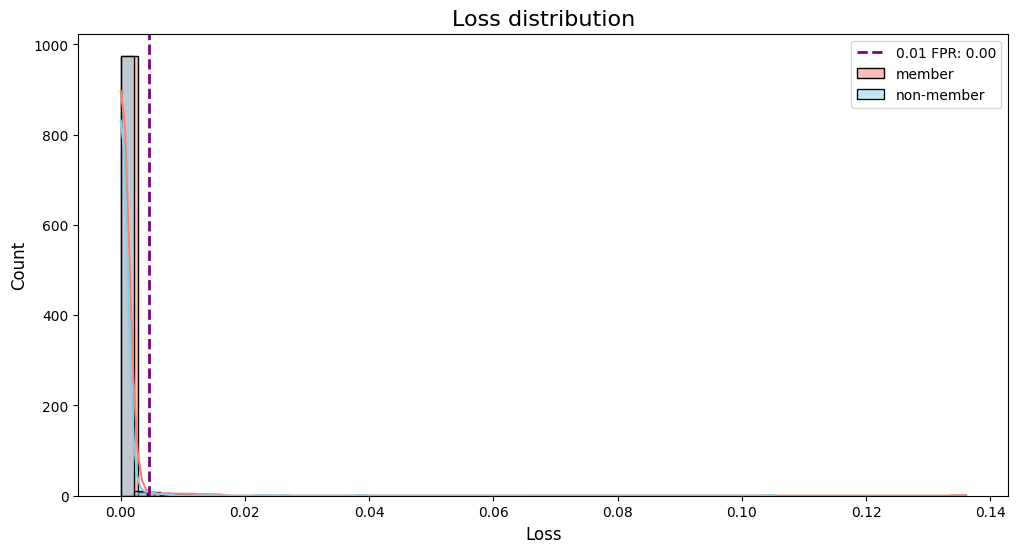

In [ ]:
# draw distribution
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.array(label_items)
scores = np.array(scores_test)

print(scores[:10])

scores_mem = scores[y_true == 1]
scores_non = scores[y_true == 0]

plt.figure(figsize=(12, 6))
sns.histplot(scores_mem, bins=50, color='salmon', kde=True, label='member')
sns.histplot(scores_non, bins=50, color='skyblue', kde=True, label='non-member')

threshold_value = np.percentile(scores_non, q=99)
print(threshold_value)
plt.axvline(
    x=threshold_value,
    color='purple',
    linestyle='--',
    linewidth=2,
    label=f'0.01 FPR: {threshold_value:.2f}'
)


plt.title('Loss distribution', fontsize=16)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)

plt.show()

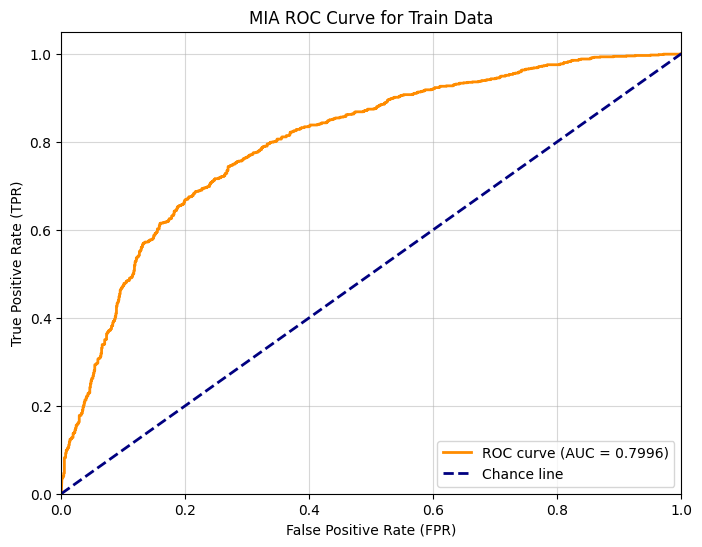

In [ ]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

**ADDITIONALS**

**Canary Dataset Gen with no test/test_json**

In [10]:
#!/usr/bin/env python
# prepare_canary_shadow_data.py
# Prepare shadow model data using canary-based partitioning (direct comparison method)

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer


def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass


def basic_clean_text(text):
    """Clean a single text string"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None
    return " ".join(text.split())


def main():
        # ========== STEP 1: Load Target Test Set (Canaries) ==========
    print("=" * 60)
    print("STEP 1: Loading Target Test Set")
    print("=" * 60)

    target_test_path = Path("./data/train/test.json")
    if not target_test_path.exists():
        raise FileNotFoundError(f"Target test file not found: {target_test_path}")

    target_test_items = json.load(open(target_test_path))
    print(f"Loaded {len(target_test_items)} test samples from target model\n")

    # ========== STEP 2: Split into 5 Canary Sets ==========
    print("=" * 60)
    print("STEP 2: Creating Canary Partitions")
    print("=" * 60)

    canary_sets = []
    canary_size = len(target_test_items) // 5

    print(f"Canary Size:{canary_size}")

    for i in range(5):
        start_idx = i * canary_size
        end_idx = (i + 1) * canary_size if i < 4 else len(target_test_items)

        # Use contiguous indices
        canary_texts = target_test_items[start_idx:end_idx]
        canary_sets.append(canary_texts)

        print(f"Canary set {i}: indices [{start_idx}, {end_idx}), {len(canary_texts)} samples")

    all_canaries_set = set(target_test_items)

    # ========== STEP 3: Load WikiText for Filling ==========
    print(f"\n{'=' * 60}")
    print("STEP 3: Loading WikiText-103")
    print("=" * 60)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    print(f"Loaded {len(wiki_raw)} WikiText samples")

    wiki_texts = []
    for item in wiki_raw:
        if "text" in item:
            cleaned = basic_clean_text(item["text"])
            if cleaned and len(cleaned) > 50:
                if cleaned not in all_canaries_set:
                    wiki_texts.append(cleaned)

    print(f"Filtered to {len(wiki_texts)} WikiText samples (excluding all canaries)\n")

    # ========== STEP 4: Create Shadow Datasets ==========
    print("=" * 60)
    print("STEP 4: Creating Shadow Model Datasets")
    print("=" * 60)

    for shadow_id in range(5):
        set_seed_all(shadow_id + 1000)
        print(f"\n--- Shadow Model {shadow_id} ---")

        # This model's canaries (members)
        my_canaries = canary_sets[shadow_id]

        # Sample WikiText to fill to 10,000 training samples
        fill_size = 10000 - len(my_canaries)

        wiki_sample = random.sample(wiki_texts, min(fill_size, len(wiki_texts)))

        # Training data: my canaries + WikiText fill
        train_data = my_canaries + wiki_sample
        random.shuffle(train_data)

        # Save to files
        out_dir = Path(f"./data/shadow_data_canary/shadow_{shadow_id}")
        out_dir.mkdir(parents=True, exist_ok=True)

        # Save train_finetune.json
        train_json = [{"text": t} for t in train_data]
        with open(out_dir / "train_finetune.json", "w", encoding="utf-8") as f:
            json.dump(train_json, f, ensure_ascii=False, indent=2)

        # Save canary mapping (which canaries this model saw)
        canary_mapping = {
            "canary_indices": list(range(shadow_id * canary_size, (shadow_id + 1) * canary_size)),
            "canary_texts": my_canaries
        }
        with open(out_dir / "canary_mapping.json", "w", encoding="utf-8") as f:
            json.dump(canary_mapping, f, ensure_ascii=False, indent=2)

        print(f"  Training: {len(train_data):,} samples")
        print(f"    - Canaries (members): {len(my_canaries)}")
        print(f"    - WikiText fill: {len(wiki_sample)}")
        print(f"    Saved to {out_dir}")

    print(f"\n{'=' * 60}")
    print("ALL SHADOW DATASETS CREATED SUCCESSFULLY")

if __name__ == "__main__":
    main()

STEP 1: Loading Target Test Set
Loaded 2000 test samples from target model

STEP 2: Creating Canary Partitions
Canary Size:400
Canary set 0: indices [0, 400), 400 samples
Canary set 1: indices [400, 800), 400 samples
Canary set 2: indices [800, 1200), 400 samples
Canary set 3: indices [1200, 1600), 400 samples
Canary set 4: indices [1600, 2000), 400 samples

STEP 3: Loading WikiText-103
Loaded 1801350 WikiText samples


KeyboardInterrupt: 

In [9]:
# Copy shadow data to Drive
!cp -r /content/18734-17731_Project_Phase2_3/data/shadow_data_canary /content/drive/MyDrive/FoundOfPriv/shadow_data_canary/

In [ ]:
# To load back:
!cp -r /content/drive/MyDrive/FoundOfPriv/shadow_data_canary/ ./data/shadow_data_canary

**For training shadow models**

In [ ]:
!python ft_llm/ft_llm_colab.py \
  --data_dir ./data/shadow_data_canary/shadow_3 \
  --train_file "train_finetune.json" \
  -m gpt2 \
  --block_size 512 \
  --epochs 3 \
  --batch_size 8 \
  --gradient_accumulation_steps 1 \
  --lr 2e-4 \
  --outdir ./models/shadow_model_canary/shadow_3/gpt2_shadow \
  --lora \
  --lora_r 32 \
  --lora_alpha 64 \
  --lora_dropout 0.05 \
  --merge_lora

!cp -r ./models/shadow_model_canary/shadow_3/ /content/drive/MyDrive/FoundOfPriv/models/shadow_3/

2025-11-07 21:33:24.130104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762551204.151399   26132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762551204.158567   26132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762551204.175748   26132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762551204.175778   26132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762551204.175795   26132 computation_placer.cc:177] computation placer alr

In [ ]:
# To copy models from drive to folder
!cp -r /content/drive/MyDrive/FoundOfPriv/models/ ./models/shadow_model_canary/

In [ ]:
!cp -r ./models/shadow_models/shadow_1/ /content/drive/MyDrive/FoundOfPriv/models/shadow_1/

**Using Shadow Models**

In [ ]:
# def get_scores():
#     print("=" * 80)
#     print("CANARY-BASED MIA: DIRECT SCORE COMPARISON")
#     print("=" * 80)

#     # Configuration - UPDATE THESE PATHS
#     TARGET_MODEL_PATH = "./models/train/gpt2_3_lora32_adamw_b8_lr2"
#     SHADOW_MODEL_DIR = "./models/shadow_model_canary/"  # Adjust if different
#     TARGET_TEST_PATH = "./data/train/test.json"
#     CANARY_DATA_DIR = "./data/shadow_data_canary"  # Where canary_data_gen.py saved data
#     MAX_LEN = 512

#     # Load target test data
#     print(f"\nLoading target test set from {TARGET_TEST_PATH}...")
#     if not Path(TARGET_TEST_PATH).exists():
#         raise FileNotFoundError(f"Target test file not found: {TARGET_TEST_PATH}")

#     target_test = json.load(open(TARGET_TEST_PATH))
#     print(f"✓ Loaded {len(target_test)} test samples")

#     # Load target model
#     if not Path(TARGET_MODEL_PATH).exists():
#         raise FileNotFoundError(f"Target model not found: {TARGET_MODEL_PATH}")

#     target_model, target_tokenizer = load_model(TARGET_MODEL_PATH)

#     # Compute target losses on ALL test samples
#     print("\n" + "=" * 80)
#     print("STEP 1: Computing Target Model Losses")
#     print("=" * 80)
#     target_losses = compute_loss_for_samples(target_model, target_tokenizer, target_test, max_len=MAX_LEN)
#     print(f"✓ Target losses computed")
#     print(f"  Mean: {target_losses.mean():.4f}")
#     print(f"  Std:  {target_losses.std():.4f}")
#     print(f"  Min:  {target_losses.min():.4f}")
#     print(f"  Max:  {target_losses.max():.4f}")

#     # Free target model memory
#     del target_model
#     torch.cuda.empty_cache()

#     # Load shadow models and compute reference distributions
#     print("\n" + "=" * 80)
#     print("STEP 2: Building Reference Distributions from Shadow Models")
#     print("=" * 80)

#     # For each canary, collect losses from shadows that saw it (member) vs didn't see it (non-member)
#     member_losses_per_canary = {}  # canary_idx -> list of losses from shadows that saw it
#     non_member_losses_per_canary = {}  # canary_idx -> list of losses from shadows that didn't see it

#     # DEBUG: Track which shadow models are successfully loaded
#     successful_shadows = []
#     all_canary_indices_seen = set()

#     for shadow_id in range(5):
#         shadow_path = Path(SHADOW_MODEL_DIR) / f"shadow_{shadow_id}" / "gpt2_shadow"
#         canary_mapping_path = Path(CANARY_DATA_DIR) / f"shadow_{shadow_id}" / "canary_mapping.json"

#         if not shadow_path.exists():
#             print(f"⚠ Shadow model {shadow_id} not found at {shadow_path}, skipping...")
#             continue

#         if not canary_mapping_path.exists():
#             print(f"⚠ Canary mapping {shadow_id} not found at {canary_mapping_path}, skipping...")
#             continue

#         print(f"\nProcessing Shadow Model {shadow_id}...")
#         shadow_model, shadow_tokenizer = load_model(str(shadow_path))

#         # Load canary mapping
#         canary_mapping = json.load(open(canary_mapping_path))
#         my_canary_indices = set(canary_mapping["canary_indices"])
#         all_canary_indices_seen.update(my_canary_indices)

#         print(f"  This shadow saw canaries: {min(my_canary_indices)} to {max(my_canary_indices)}")
#         print(f"  Total canaries for this shadow: {len(my_canary_indices)}")

#         # Compute losses on ALL target test samples
#         shadow_losses = compute_loss_for_samples(shadow_model, shadow_tokenizer, target_test, max_len=MAX_LEN)
#         print(f"  Shadow losses computed: mean={shadow_losses.mean():.4f}")

#         # Categorize losses
#         member_count = 0
#         non_member_count = 0

#         for idx, loss in enumerate(shadow_losses):
#             if idx in my_canary_indices:
#                 # This shadow saw this canary (member)
#                 if idx not in member_losses_per_canary:
#                     member_losses_per_canary[idx] = []
#                 member_losses_per_canary[idx].append(loss)
#                 member_count += 1
#             else:
#                 # This shadow didn't see this canary (non-member)
#                 if idx not in non_member_losses_per_canary:
#                     non_member_losses_per_canary[idx] = []
#                 non_member_losses_per_canary[idx].append(loss)
#                 non_member_count += 1

#         print(f"  Categorized: {member_count} member losses, {non_member_count} non-member losses")
#         successful_shadows.append(shadow_id)

#         del shadow_model  # Free memory
#         torch.cuda.empty_cache()

#     # DEBUG: Print statistics about the reference distributions
#     print(f"\n{'='*80}")
#     print("REFERENCE DISTRIBUTION STATISTICS")
#     print("="*80)
#     print(f"Successfully loaded {len(successful_shadows)} shadow models: {successful_shadows}")
#     print(f"Total test samples: {len(target_test)}")
#     print(f"All canary indices seen across shadows: {min(all_canary_indices_seen)} to {max(all_canary_indices_seen)}")

#     # Count how many samples have both member and non-member references
#     samples_with_both = 0
#     samples_missing_member = 0
#     samples_missing_non_member = 0
#     samples_missing_both = 0

#     for idx in range(len(target_test)):
#         has_member = idx in member_losses_per_canary and len(member_losses_per_canary[idx]) > 0
#         has_non_member = idx in non_member_losses_per_canary and len(non_member_losses_per_canary[idx]) > 0

#         if has_member and has_non_member:
#             samples_with_both += 1
#         elif has_member and not has_non_member:
#             samples_missing_non_member += 1
#         elif not has_member and has_non_member:
#             samples_missing_member += 1
#         else:
#             samples_missing_both += 1

#     print(f"Samples with both member & non-member refs: {samples_with_both}")
#     print(f"Samples missing non-member refs only: {samples_missing_non_member}")
#     print(f"Samples missing member refs only: {samples_missing_member}")
#     print(f"Samples missing both refs: {samples_missing_both}")

#     # Show some examples of problematic samples
#     print(f"\nFirst 10 samples analysis:")
#     for idx in range(min(10, len(target_test))):
#         member_losses = member_losses_per_canary.get(idx, [])
#         non_member_losses = non_member_losses_per_canary.get(idx, [])
#         print(f"  Sample {idx}: {len(member_losses)} member refs, {len(non_member_losses)} non-member refs")

#     # STEP 3: Make predictions using distribution comparison
#     print("\n" + "=" * 80)
#     print("STEP 3: Predicting Membership via Distribution Comparison")
#     print("=" * 80)

#     predictions = []
#     scores = []  # Membership scores (higher = more likely member)
#     method_stats = {"distance": 0, "threshold": 0, "neutral": 0}

#     for idx in range(len(target_test)):
#         target_loss = target_losses[idx]

#         # Get reference distributions
#         member_losses = member_losses_per_canary.get(idx, [])
#         non_member_losses = non_member_losses_per_canary.get(idx, [])

#         if not member_losses or not non_member_losses:
#             score = 0.5
#             method_stats["neutral"] += 1

#             # DEBUG: Print why this sample got 0.5
#             if idx < 20:  # Only print for first 20 to avoid spam
#                 reason = []
#                 if not member_losses:
#                     reason.append("no member refs")
#                 if not non_member_losses:
#                     reason.append("no non-member refs")
#                 print(f"  Sample {idx} -> 0.5 ({', '.join(reason)})")
#         else:
#             member_mean = np.mean(member_losses)
#             non_member_mean = np.mean(non_member_losses)

#             # Score based on how much closer target loss is to member vs non-member mean
#             # Use negative loss: lower loss = higher membership probability
#             if member_mean < non_member_mean:  # Members should have lower loss
#                 # Normalize between member and non-member means
#                 if target_loss <= member_mean:
#                     score = 1.0  # Very likely member
#                 elif target_loss >= non_member_mean:
#                     score = 0.0  # Very likely non-member
#                 else:
#                     # Linear interpolation
#                     score = 1.0 - (target_loss - member_mean) / (non_member_mean - member_mean)
#             else:
#                 # Fallback if distributions are inverted
#                 score = 0.5

#             # Clip to [0, 1]
#             score = np.clip(score, 0.0, 1.0)
#             method_stats["distance"] += 1

#         scores.append(score)
#         predictions.append(1 if score > 0.5 else 0)

#     print(f"\nMethod statistics:")
#     print(f"  Distance comparison: {method_stats['distance']}")
#     print(f"  Neutral (0.5): {method_stats['neutral']}")
#     print(f"  Percentage neutral: {method_stats['neutral']/len(target_test)*100:.1f}%")

#     print(f"✓ Computed {len(scores)} membership scores")
#     return np.array(scores)

In [ ]:
def model_build():
    print("=" * 80)
    print("CANARY-BASED MIA: CALIBRATED SCORE COMPARISON")
    print("=" * 80)

    # Configuration - same as before
    TARGET_MODEL_PATH = "./models/train/gpt2_3_lora32_adamw_b8_lr2"
    SHADOW_MODEL_DIR = "./models/shadow_model_canary/"
    TARGET_TEST_PATH = "./data/train/test.json"
    CANARY_DATA_DIR = "./data/shadow_data_canary"
    MAX_LEN = 512

    # Load data and compute losses (same as before)
    target_test = json.load(open(TARGET_TEST_PATH))
    target_model, target_tokenizer = load_model(TARGET_MODEL_PATH)
    target_losses = compute_loss_for_samples(target_model, target_tokenizer, target_test, max_len=MAX_LEN)

    del target_model
    torch.cuda.empty_cache()

    # Build reference distributions (same as before)
    member_losses_per_canary = {}
    non_member_losses_per_canary = {}

    for shadow_id in range(5):
        shadow_path = Path(SHADOW_MODEL_DIR) / f"shadow_{shadow_id}" / "gpt2_shadow"
        canary_mapping_path = Path(CANARY_DATA_DIR) / f"shadow_{shadow_id}" / "canary_mapping.json"

        if not shadow_path.exists() or not canary_mapping_path.exists():
            continue

        shadow_model, shadow_tokenizer = load_model(str(shadow_path))
        canary_mapping = json.load(open(canary_mapping_path))
        my_canary_indices = set(canary_mapping["canary_indices"])

        shadow_losses = compute_loss_for_samples(shadow_model, shadow_tokenizer, target_test, max_len=MAX_LEN)

        for idx, loss in enumerate(shadow_losses):
            if idx in my_canary_indices:
                if idx not in member_losses_per_canary:
                    member_losses_per_canary[idx] = []
                member_losses_per_canary[idx].append(loss)
            else:
                if idx not in non_member_losses_per_canary:
                    non_member_losses_per_canary[idx] = []
                non_member_losses_per_canary[idx].append(loss)

        del shadow_model
        torch.cuda.empty_cache()
    return target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary

In [ ]:
# APPROACH 1: Log-Likelihood Ratio (Numerically Stable)
# This fixes the numerical instability while keeping the probabilistic interpretation
def get_scores_log_likelihood(target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary):
    """
    Use log-likelihood ratios to avoid numerical underflow.
    Score = log P(loss | member) - log P(loss | non-member)
    Higher score = more likely member
    """
    from scipy.stats import norm
    scores = []

    for idx in range(len(target_test)):
        target_loss = target_losses[idx]
        member_losses = member_losses_per_canary.get(idx, [])
        non_member_losses = non_member_losses_per_canary.get(idx, [])

        if not member_losses or not non_member_losses:
            score = 0.0  # Neutral score
        else:
            member_mean = np.mean(member_losses)
            member_std = np.std(member_losses) if len(member_losses) > 1 else 0.1

            non_member_mean = np.mean(non_member_losses)
            non_member_std = np.std(non_member_losses) if len(non_member_losses) > 1 else 0.1

            # Log-likelihood under each distribution
            log_prob_member = norm.logpdf(target_loss, member_mean, member_std + 1e-6)
            log_prob_non_member = norm.logpdf(target_loss, non_member_mean, non_member_std + 1e-6)

            # Likelihood ratio in log space (higher = more likely member)
            score = log_prob_member - log_prob_non_member

        scores.append(score)

    scores = np.array(scores)
    # Normalize to [0, 1] using sigmoid
    scores = 1 / (1 + np.exp(-scores))

    print(f"✓ Log-likelihood scores: min={scores.min():.4f}, max={scores.max():.4f}, mean={scores.mean():.4f}")
    return scores

def get_scores(target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary):
    """
    Main scoring function - using log-likelihood ratio for numerical stability
    """
    return get_scores_log_likelihood(target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary)

In [ ]:
#!/usr/bin/env python
"""
Canary-based MIA using direct score comparison (no attack classifier)
For each test sample, compare target model loss vs shadow model reference distributions
"""

import json
import numpy as np
import torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


def compute_loss_for_samples(model, tokenizer, texts, max_len=512, batch_size=4):
    """Compute per-sample loss"""
    model.eval()
    device = next(model.parameters()).device
    losses = []

    print(f"Computing losses for {len(texts)} samples...")

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encodings = tokenizer(
                batch_texts,
                max_length=max_len,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )

            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            # Compute loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

            # Per-sample loss (mean over sequence length)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss.view(shift_labels.size())

            # Mask and average
            loss = (loss * shift_mask).sum(dim=1) / shift_mask.sum(dim=1)
            losses.extend(loss.cpu().numpy().tolist())

    return np.array(losses)

def compute_loss_with_variance(model, tokenizer, texts, max_len=512, batch_size=4):
    """
    Compute both mean loss and loss variance per sample.
    Members may have more consistent (lower variance) losses.
    """
    model.eval()
    device = next(model.parameters()).device
    losses_mean = []
    losses_std = []

    print(f"Computing enhanced losses for {len(texts)} samples...")

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            encodings = tokenizer(
                batch_texts,
                max_length=max_len,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )

            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

            # Per-token loss
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss.view(shift_labels.size())

            # Compute both mean and std per sample
            for j in range(loss.size(0)):
                sample_loss = loss[j]
                sample_mask = shift_mask[j]

                valid_losses = sample_loss[sample_mask.bool()]

                if len(valid_losses) > 0:
                    losses_mean.append(valid_losses.mean().cpu().item())
                    losses_std.append(valid_losses.std().cpu().item())
                else:
                    losses_mean.append(0.0)
                    losses_std.append(0.0)

    return np.array(losses_mean), np.array(losses_std)


def load_model(model_path):
    """Load a fine-tuned model"""
    print(f"Loading model from {model_path}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if torch.cuda.is_available():
        model = model.cuda()
        print(f"✓ Model loaded on GPU")
    else:
        print(f"✓ Model loaded on CPU")

    return model, tokenizer


def main():
    print(f"Prediction methods used:")
    print(f"  Distance comparison: {method_stats['distance']}")
    print(f"  Neutral (missing ref): {method_stats['neutral']}")

    print(f"Scores min: {min(scores):.4f}")
    print(f"Scores max: {max(scores):.4f}")

    # Save predictions
    print("\n" + "=" * 80)
    print("STEP 4: Saving Results")
    print("=" * 80)

    # Save scores
    with open("predictions_scores_direct.json", "w") as f:
        json.dump(scores, f, indent=2)

    # Save binary predictions
    with open("predictions_direct.json", "w") as f:
        json.dump(predictions, f, indent=2)

    print(f"✓ Predictions saved")
    print(f"  - Predicted members: {sum(predictions)}")
    print(f"  - Predicted non-members: {len(predictions) - sum(predictions)}")
    print(f"  - Mean score: {np.mean(scores):.4f}")

    # Check for validation labels
    label_paths = [
        "./18734-17731_Project_Phase2_3/data/train/test_label.json",
        "./data/train/test_label.json"
    ]

    labels = None
    for label_path in label_paths:
        if Path(label_path).exists():
            labels = json.load(open(label_path))
            print(f"✓ Found validation labels at {label_path}")
            break

    if labels is not None:
        print("\n" + "=" * 80)
        print("VALIDATION METRICS")
        print("=" * 80)

        auc = roc_auc_score(labels, scores)
        print(f"AUC: {auc:.4f}")


        # Calculate accuracy metrics
        correct_predictions = sum(1 for true_label, pred_label in zip(labels, predictions) if true_label == pred_label)
        total_predictions = len(labels)
        accuracy = correct_predictions / total_predictions

        # Member and non-member accuracy
        member_correct = sum(1 for true_label, pred_label in zip(labels, predictions) if true_label == 1 and pred_label == 1)
        member_total = sum(labels)
        member_accuracy = member_correct / member_total if member_total > 0 else 0

        non_member_correct = sum(1 for true_label, pred_label in zip(labels, predictions) if true_label == 0 and pred_label == 0)
        non_member_total = len(labels) - sum(labels)
        non_member_accuracy = non_member_correct / non_member_total if non_member_total > 0 else 0

        print(f"\nACCURACY METRICS:")
        print(f"  Overall Accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions})")
        print(f"  Member Accuracy (Recall): {member_accuracy:.4f} ({member_correct}/{member_total})")
        print(f"  Non-member Accuracy (Specificity): {non_member_accuracy:.4f} ({non_member_correct}/{non_member_total})")

        # Confusion Matrix
        true_positives = member_correct
        false_positives = sum(1 for true_label, pred_label in zip(labels, predictions) if true_label == 0 and pred_label == 1)
        true_negatives = non_member_correct
        false_negatives = sum(1 for true_label, pred_label in zip(labels, predictions) if true_label == 1 and pred_label == 0)

        print(f"\nCONFUSION MATRIX:")
        print(f"  True Positives (Correctly identified members): {true_positives}")
        print(f"  False Positives (Non-members predicted as members): {false_positives}")
        print(f"  True Negatives (Correctly identified non-members): {true_negatives}")
        print(f"  False Negatives (Members predicted as non-members): {false_negatives}")

        # TPR @ 1% FPR
        fpr, tpr, thresholds = roc_curve(labels, scores)
        idx_1fpr = np.where(fpr <= 0.01)[0]
        if len(idx_1fpr) > 0:
            tpr_at_1fpr = tpr[idx_1fpr[-1]]
            print(f"TPR @ 1% FPR: {tpr_at_1fpr:.4f}")

            if tpr_at_1fpr > 0.15:
                print("✅ SUCCESS: TPR @ 1% FPR > 0.15 (Phase 2 requirement met!)")
            else:
                print("❌ TPR @ 1% FPR < 0.15 (Phase 2 requirement not met)")

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'Direct Comparison (AUC = {auc:.4f})')
        plt.axvline(0.01, color='r', linestyle='--', label='1% FPR', alpha=0.7)
        if len(idx_1fpr) > 0:
            plt.axhline(tpr_at_1fpr, color='r', linestyle='--', alpha=0.7)
            plt.plot(0.01, tpr_at_1fpr, 'ro', markersize=8, label=f'TPR@1%FPR = {tpr_at_1fpr:.4f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Canary-based MIA (Direct Comparison)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Analyze per-canary performance
        member_indices = [i for i, label in enumerate(labels) if label == 1]
        non_member_indices = [i for i, label in enumerate(labels) if label == 0]

        member_scores = [scores[i] for i in member_indices]
        non_member_scores = [scores[i] for i in non_member_indices]

        print(f"\nScore distributions:")
        print(f"  Members (should be high):     mean={np.mean(member_scores):.4f}, std={np.std(member_scores):.4f}")
        print(f"  Non-members (should be low):  mean={np.mean(non_member_scores):.4f}, std={np.std(non_member_scores):.4f}")

    else:
        print("\n⚠ No validation labels found - running in inference mode")
        print("Results saved for submission to validation/final phases")


In [ ]:
target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary = model_build()

CANARY-BASED MIA: CALIBRATED SCORE COMPARISON
Loading model from ./models/train/gpt2_3_lora32_adamw_b8_lr2...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:47<00:00,  4.64it/s]


Loading model from models/shadow_model_canary/shadow_0/gpt2_shadow...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


Loading model from models/shadow_model_canary/shadow_1/gpt2_shadow...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:36<00:00,  5.18it/s]


Loading model from models/shadow_model_canary/shadow_2/gpt2_shadow...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


Loading model from models/shadow_model_canary/shadow_3/gpt2_shadow...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


Loading model from models/shadow_model_canary/shadow_4/gpt2_shadow...
✓ Model loaded on GPU
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


In [ ]:
scores_test = get_scores(target_test, target_losses, member_losses_per_canary, non_member_losses_per_canary)
#main()

✓ Log-likelihood scores: min=0.0173, max=1.0000, mean=0.4633
✓ Percentile scores: min=0.0000, max=1.0000, mean=0.3921
✓ Robust margin scores: min=0.0000, max=0.1361, mean=0.0005
✓ Ensemble scores: min=0.0069, max=0.6834, mean=0.3031


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

**OLD CODE**

In [ ]:
#!/usr/bin/env python
# prepare_data.py
# curate training data for the model

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

# dataset - seed
# 0 - 4042
# 1 - 3042
# 2 - 2042
# 3 - 1042
# 4 - 420

OUTDIR = "shadow_data/shadow_0"
SEED = 4042
TRAIN_PER_SRC = 10_000
MIN_TOKENS = 25
TEST_MEMBERS = 1000
TEST_NONMEMBERS = 1000

def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed); np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def ensure_text_column(ds: Dataset, src: str) -> Dataset:
    if src == "wikitext103":
        assert "text" in ds.column_names
        return ds.remove_columns([c for c in ds.column_names if c != "text"])
    raise ValueError(src)

def basic_clean(ds: Dataset) -> Dataset:
    ds = ds.filter(lambda ex: isinstance(ex.get("text", None), str) and len(ex["text"].strip()) > 0)
    def _strip_map(ex): return {"text": " ".join(ex["text"].split())}
    return ds.map(_strip_map, batched=False)

def filter_by_tokens(ds: Dataset, tok, min_tokens: int) -> Dataset:
    def _len_map(batch):
        enc = tok(batch["text"], add_special_tokens=False)
        return {"_tok_len": [len(ids) for ids in enc["input_ids"]]}
    ds = ds.map(_len_map, batched=True)
    ds = ds.filter(lambda ex: ex["_tok_len"] >= min_tokens)
    return ds.remove_columns(["_tok_len"])

def sample_n(ds: Dataset, n: int, seed: int):
    n = min(n, len(ds))
    idx = list(range(len(ds)))
    random.Random(seed).shuffle(idx)
    take = sorted(idx[:n])
    return ds.select(take), set(take)

def dump_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def main():
    set_seed_all(SEED)
    os.makedirs(OUTDIR, exist_ok=True)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    # ---------- Load & filter (WikiText-103-raw-v1) ----------
    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    wiki = ensure_text_column(wiki_raw, "wikitext103")
    wiki = basic_clean(wiki)
    wiki = filter_by_tokens(wiki, tok, MIN_TOKENS)

    # train set
    wiki_train, wiki_train_idx = sample_n(wiki, TRAIN_PER_SRC, SEED + 1)

    out_dir = Path(OUTDIR)
    train_json = [{"text": ex["text"]} for ex in wiki_train]
    dump_json(out_dir / "train_finetune.json", train_json)

    train_texts = [ex["text"] for ex in wiki_train]
    train_set = set(train_texts)

    # Get member samples (from training set)
    member_samples = random.sample(train_texts, min(TEST_MEMBERS, len(train_texts)))

    # Get non-member samples (from wiki but NOT in training)
    nonmember_candidates = [ex["text"] for ex in wiki if ex["text"] not in train_set]
    nonmember_samples = random.sample(nonmember_candidates, min(TEST_NONMEMBERS, len(nonmember_candidates)))

    # Combine: members first, then non-members
    test_texts = member_samples + nonmember_samples
    test_labels = [1] * len(member_samples) + [0] * len(nonmember_samples)

    # Save test.json and test_label.json
    dump_json(out_dir / "test.json", test_texts)
    dump_json(out_dir / "test_label.json", test_labels)

    print(f"[OK] Train JSON ({len(train_texts)} samples) saved to {OUTDIR}")
    print(f"[OK] Test JSON ({len(member_samples)} members + {len(nonmember_samples)} non-members) saved to {OUTDIR}")


    print("[OK] JSON saved to", OUTDIR)

if __name__ == "__main__":
    main()


[OK] Train JSON (10000 samples) saved to shadow_data/shadow_0
[OK] Test JSON (1000 members + 1000 non-members) saved to shadow_data/shadow_0
[OK] JSON saved to shadow_data/shadow_0


In [ ]:
#!/usr/bin/env python
# prepare_canary_shadow_data.py
# Prepare shadow model data using canary-based partitioning

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def basic_clean_text(text):
    """Clean a single text string"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None
    return " ".join(text.split())

def main():
    set_seed_all(42)  # Global seed for reproducibility

    # ========== STEP 1: Load Target Test Set (Canaries) ==========
    print("="*60)
    print("STEP 1: Loading Target Test Set")
    print("="*60)

    target_test_path = Path("./data/train/test.json")
    if not target_test_path.exists():
        raise FileNotFoundError(f"Target test file not found: {target_test_path}")

    target_test_items = json.load(open(target_test_path))
    print(f"Loaded {len(target_test_items)} test samples from target model\n")

    # ========== STEP 2: Split into 5 Canary Sets ==========
    print("="*60)
    print("STEP 2: Creating Canary Partitions")
    print("="*60)

    # Shuffle with fixed seed
    random.seed(42)
    shuffled_indices = list(range(len(target_test_items)))
    random.shuffle(shuffled_indices)

    canary_sets = []
    canary_size = len(target_test_items) // 5

    for i in range(5):
        start_idx = i * canary_size
        end_idx = (i + 1) * canary_size if i < 4 else len(target_test_items)
        canary_indices = shuffled_indices[start_idx:end_idx]
        canary_texts = [target_test_items[idx] for idx in canary_indices]
        canary_sets.append(canary_texts)
        print(f"Canary set {i}: {len(canary_texts)} samples")

    # Convert to sets for fast lookup
    canary_sets_lookup = [set(texts) for texts in canary_sets]
    all_canaries_set = set(target_test_items)

    # ========== STEP 3: Load WikiText for Filling ==========
    print(f"\n{'='*60}")
    print("STEP 3: Loading WikiText-103")
    print("="*60)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    print(f"✓ Loaded {len(wiki_raw)} WikiText samples")

    # Clean and filter WikiText, excluding ALL canaries
    wiki_texts = []
    for item in wiki_raw:
        if "text" in item:
            cleaned = basic_clean_text(item["text"])
            if cleaned and len(cleaned) > 50:  # Min length filter
                # Exclude all target test samples
                if cleaned not in all_canaries_set:
                    wiki_texts.append(cleaned)

    print(f"Filtered to {len(wiki_texts)} WikiText samples (excluding all canaries)\n")

    # ========== STEP 4: Create Shadow Datasets ==========
    print("="*60)
    print("STEP 4: Creating Shadow Model Datasets")
    print("="*60)

    for shadow_id in range(5):
        print(f"\n--- Shadow Model {shadow_id} ---")

        # This model's canaries (members)
        my_canaries = canary_sets[shadow_id]

        # Other models' canaries (non-members for testing)
        other_canaries = []
        for j in range(5):
            if j != shadow_id:
                other_canaries.extend(canary_sets[j])

        # Sample only 400 non-members to match members**
        random.seed(shadow_id + 2000)
        sampled_non_members = random.sample(other_canaries, len(my_canaries))

        # Sample WikiText to fill to 10,000 training samples
        fill_size = 10000 - len(my_canaries)
        random.seed(shadow_id + 1000)
        wiki_sample = random.sample(wiki_texts, min(fill_size, len(wiki_texts)))

        # Training data: my canaries + WikiText fill
        train_data = my_canaries + wiki_sample
        random.shuffle(train_data)

        # Test data: BALANCED 400 members + 400 non-members
        test_data = my_canaries + sampled_non_members
        test_labels = [1] * len(my_canaries) + [0] * len(sampled_non_members)

        # Shuffle test data with labels together
        combined = list(zip(test_data, test_labels))
        random.shuffle(combined)
        test_data, test_labels = zip(*combined)
        test_data = list(test_data)
        test_labels = list(test_labels)

        # Save to files
        out_dir = Path(f"./data/shadow_data_canary/shadow_{shadow_id}")
        out_dir.mkdir(parents=True, exist_ok=True)

        # Save train_finetune.json
        train_json = [{"text": t} for t in train_data]
        with open(out_dir / "train_finetune.json", "w", encoding="utf-8") as f:
            json.dump(train_json, f, ensure_ascii=False, indent=2)

        # Save test.json
        with open(out_dir / "test.json", "w", encoding="utf-8") as f:
            json.dump(test_data, f, ensure_ascii=False, indent=2)

        # Save test_label.json
        with open(out_dir / "test_label.json", "w", encoding="utf-8") as f:
            json.dump(test_labels, f, ensure_ascii=False, indent=2)

        print(f"  Training: {len(train_data):,} samples")
        print(f"    - Canaries (members): {len(my_canaries)}")
        print(f"    - WikiText fill: {len(wiki_sample)}")
        print(f"  Test: {len(test_data):,} samples")
        print(f"    - Members: {sum(test_labels)}")
        print(f"    - Non-members: {len(test_labels) - sum(test_labels)}")
        print(f"    Saved to {out_dir}")

    print(f"\n{'='*60}")
    print("ALL SHADOW DATASETS CREATED SUCCESSFULLY")

if __name__ == "__main__":
    main()

STEP 1: Loading Target Test Set
Loaded 2000 test samples from target model

STEP 2: Creating Canary Partitions
Canary set 0: 400 samples
Canary set 1: 400 samples
Canary set 2: 400 samples
Canary set 3: 400 samples
Canary set 4: 400 samples

STEP 3: Loading WikiText-103


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

✓ Loaded 1801350 WikiText samples
Filtered to 795044 WikiText samples (excluding all canaries)

STEP 4: Creating Shadow Model Datasets

--- Shadow Model 0 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_0

--- Shadow Model 1 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_1

--- Shadow Model 2 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_2

--- Shadow Model 3 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/sh

**Quantile**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import json
from pathlib import Path

def pinball_loss_fn(predicted_quantiles, target_scores, quantile_levels):
    """
    Pinball loss for quantile regression
    predicted_quantiles: [batch_size, n_quantiles]
    target_scores: [batch_size, 1]
    quantile_levels: [1, n_quantiles]
    """
    target_scores = target_scores.unsqueeze(-1)  # [batch_size, 1]
    delta = target_scores - predicted_quantiles  # [batch_size, n_quantiles]

    loss = torch.where(
        delta >= 0,
        delta * quantile_levels,
        delta * (quantile_levels - 1.0)
    )
    return loss.mean()

def compute_llm_score(model, tokenizer, text, max_len=512, device='cuda'):
    """
    Compute per-sample loss for a text using the LLM
    Lower loss = more likely to be a training member
    """
    model.eval()

    with torch.no_grad():
        # Tokenize
        encoding = tokenizer(
            text,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        # Compute loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

        # Per-token loss calculation
        shift_logits = outputs.logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        shift_mask = attention_mask[:, 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        loss = loss.view(shift_labels.size())

        # Mask and average
        per_sample_loss = (loss * shift_mask).sum(dim=1) / shift_mask.sum(dim=1)

    return per_sample_loss.cpu().item()

print("✓ Chunk 1: Core functions loaded")

✓ Chunk 1: Core functions loaded


In [ ]:
class TextFeatureExtractor(nn.Module):
    """
    Simple feature extractor that converts text statistics to features
    for quantile regression
    """
    def __init__(self, input_dim=10, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.feature_dim = hidden_dim // 2

    def forward(self, x):
        return self.network(x)

def extract_text_features(text, tokenizer):
    """
    Extract simple statistical features from text
    """
    # Basic text statistics
    text_len = len(text)
    word_count = len(text.split())
    char_count = len(text)
    avg_word_len = char_count / max(word_count, 1)

    # Tokenizer-based features
    tokens = tokenizer.encode(text, add_special_tokens=False)
    token_count = len(tokens)
    unique_tokens = len(set(tokens))
    token_diversity = unique_tokens / max(token_count, 1)

    # Character-level features
    alpha_ratio = sum(c.isalpha() for c in text) / max(len(text), 1)
    digit_ratio = sum(c.isdigit() for c in text) / max(len(text), 1)
    space_ratio = sum(c.isspace() for c in text) / max(len(text), 1)

    features = torch.tensor([
        text_len / 1000.0,  # Normalize
        word_count / 100.0,
        avg_word_len / 10.0,
        token_count / 100.0,
        token_diversity,
        alpha_ratio,
        digit_ratio,
        space_ratio,
        min(text_len, 2000) / 2000.0,  # Capped length
        min(token_count, 500) / 500.0   # Capped tokens
    ], dtype=torch.float32)

    return features

print("✓ Chunk 2: Feature extractor loaded")

✓ Chunk 2: Feature extractor loaded


In [ ]:
class QuantileRegressor(nn.Module):
    """
    Quantile regression model that predicts multiple quantiles
    """
    def __init__(self, feature_dim=32, n_quantiles=50):
        super().__init__()
        self.feature_extractor = TextFeatureExtractor(input_dim=10, hidden_dim=64)

        self.quantile_head = nn.Sequential(
            nn.Linear(self.feature_extractor.feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_quantiles)
        )

    def forward(self, text_features):
        features = self.feature_extractor(text_features)
        quantiles = self.quantile_head(features)
        return quantiles

def prepare_auxiliary_data(auxiliary_texts, target_model, tokenizer, device='cuda', batch_size=8):
    """
    Prepare auxiliary dataset by computing scores and features
    """
    print(f"Preparing auxiliary data from {len(auxiliary_texts)} samples...")

    all_features = []
    all_scores = []

    # Process in batches to avoid memory issues
    for i in range(0, len(auxiliary_texts), batch_size):
        batch_texts = auxiliary_texts[i:i+batch_size]

        # Extract features and scores for this batch
        batch_features = []
        batch_scores = []

        for text in batch_texts:
            # Extract statistical features
            features = extract_text_features(text, tokenizer)
            batch_features.append(features)

            # Compute LLM score (loss)
            score = compute_llm_score(target_model, tokenizer, text, device=device)
            batch_scores.append(score)

        all_features.extend(batch_features)
        all_scores.extend(batch_scores)

        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i + len(batch_texts)}/{len(auxiliary_texts)} samples")

    # Convert to tensors
    features_tensor = torch.stack(all_features)
    scores_tensor = torch.tensor(all_scores, dtype=torch.float32)

    print(f"✓ Auxiliary data prepared: {len(all_scores)} samples")
    print(f"  Score stats: min={min(all_scores):.4f}, max={max(all_scores):.4f}, mean={np.mean(all_scores):.4f}")

    return features_tensor, scores_tensor

print("✓ Chunk 3: Quantile regression model loaded")

✓ Chunk 3: Quantile regression model loaded


In [ ]:
def train_quantile_regressor(features, scores, n_quantiles=50, num_epochs=100,
                           learning_rate=0.001, batch_size=32, device='cuda'):
    """
    Train the quantile regression model
    """
    print(f"Training quantile regressor with {n_quantiles} quantiles...")

    # Setup quantile levels
    quantile_levels = torch.linspace(0.01, 0.99, n_quantiles).unsqueeze(0).to(device)
    #print(f"Quantile levels: {first_5} ... {last_5}")

    # Create model
    model = QuantileRegressor(n_quantiles=n_quantiles).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create data loader
    dataset = TensorDataset(features, scores)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_features, batch_scores in dataloader:
            batch_features = batch_features.to(device)
            batch_scores = batch_scores.to(device)

            # Forward pass
            predicted_quantiles = model(batch_features)

            # Compute pinball loss
            loss = pinball_loss_fn(predicted_quantiles, batch_scores, quantile_levels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    print("✓ Training completed")
    return model, quantile_levels

print("✓ Chunk 4: Training functions loaded")

✓ Chunk 4: Training functions loaded


In [ ]:
def quantile_mia_attack(target_model, tokenizer, target_texts, auxiliary_texts,
                       alpha=0.05, n_quantiles=50, device='cuda'):
    """
    Main quantile regression MIA attack
    """
    print("="*60)
    print("QUANTILE REGRESSION MIA ATTACK")
    print("="*60)

    # Step 1: Prepare auxiliary data
    print("\nStep 1: Preparing auxiliary dataset...")
    aux_features, aux_scores = prepare_auxiliary_data(
        auxiliary_texts, target_model, tokenizer, device=device
    )

    # Step 2: Train quantile regressor
    print(f"\nStep 2: Training quantile regressor (α={alpha})...")
    quantile_model, quantile_levels = train_quantile_regressor(
        aux_features, aux_scores, n_quantiles=n_quantiles, device=device
    )

    # Step 3: Attack target samples
    print(f"\nStep 3: Attacking {len(target_texts)} target samples...")

    attack_scores = []
    quantile_model.eval()

    # Find the quantile index closest to (1 - alpha)
    target_quantile = 1 - alpha
    quantile_idx = torch.argmin(torch.abs(quantile_levels.squeeze() - target_quantile)).item()
    actual_quantile = quantile_levels.squeeze()[quantile_idx].item()

    print(f"Using quantile {actual_quantile:.3f} (target: {target_quantile:.3f})")

    with torch.no_grad():
        for i, text in enumerate(target_texts):
            # Extract features for target sample
            text_features = extract_text_features(text, tokenizer).unsqueeze(0).to(device)

            # Compute actual score from target model
            actual_score = compute_llm_score(target_model, tokenizer, text, device=device)

            # Predict quantiles using trained model
            predicted_quantiles = quantile_model(text_features)
            threshold = predicted_quantiles[0, quantile_idx].item()

            # Attack score: how much lower is actual score vs predicted threshold
            # Higher attack_score = more likely to be member
            attack_score = threshold - actual_score
            attack_scores.append(attack_score)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i+1}/{len(target_texts)} samples")

    print(f"✓ Attack completed")
    print(f"  Attack scores: min={min(attack_scores):.4f}, max={max(attack_scores):.4f}")
    print(f"  Mean: {np.mean(attack_scores):.4f}, Std: {np.std(attack_scores):.4f}")

    return np.array(attack_scores)

print("✓ Chunk 5: Attack implementation loaded")

✓ Chunk 5: Attack implementation loaded


In [ ]:
def run_quantile_attack():
    """
    Integration function to run quantile attack with your existing setup
    """
    print("Starting Quantile Regression MIA Attack...")

    # Use your existing model and data
    target_test_samples = test_items  # Your existing test data

    # Load auxiliary data (WikiText samples not in training)
    # You can use the same WikiText loading code you have in the canary generation
    print("Loading auxiliary data...")
    from datasets import load_dataset

    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    auxiliary_texts = []
    target_set = set(target_test_samples)

    for item in wiki_raw:
        if "text" in item:
            cleaned = " ".join(item["text"].split())
            if len(cleaned) > 50 and cleaned not in target_set:
                auxiliary_texts.append(cleaned)
                if len(auxiliary_texts) >= 5000:  # Limit for memory
                    break

    print(f"Loaded {len(auxiliary_texts)} auxiliary samples")

    # Run the attack
    attack_scores = quantile_mia_attack(
        target_model=model,
        tokenizer=tokenizer,
        target_texts=target_test_samples,
        auxiliary_texts=auxiliary_texts,
        alpha=0.01,  # 1% FPR
        device=device
    )

    return attack_scores

# To use this, simply call:
# scores_test = run_quantile_attack()

print("✓ Chunk 6: Integration ready")
print("\nTo run the attack, execute: scores_test = run_quantile_attack()")

✓ Chunk 6: Integration ready

To run the attack, execute: scores_test = run_quantile_attack()


In [ ]:
scores_test = run_quantile_attack()

Starting Quantile Regression MIA Attack...
Loading auxiliary data...
Loaded 5000 auxiliary samples
QUANTILE REGRESSION MIA ATTACK

Step 1: Preparing auxiliary dataset...
Preparing auxiliary data from 5000 samples...
  Processed 80/5000 samples
  Processed 160/5000 samples
  Processed 240/5000 samples
  Processed 320/5000 samples
  Processed 400/5000 samples
  Processed 480/5000 samples
  Processed 560/5000 samples
  Processed 640/5000 samples
  Processed 720/5000 samples
  Processed 800/5000 samples
  Processed 880/5000 samples
  Processed 960/5000 samples
  Processed 1040/5000 samples
  Processed 1120/5000 samples
  Processed 1200/5000 samples
  Processed 1280/5000 samples
  Processed 1360/5000 samples
  Processed 1440/5000 samples
  Processed 1520/5000 samples
  Processed 1600/5000 samples
  Processed 1680/5000 samples
  Processed 1760/5000 samples
  Processed 1840/5000 samples
  Processed 1920/5000 samples
  Processed 2000/5000 samples
  Processed 2080/5000 samples
  Processed 2160/